# Pre_processing

In [ ]:
## Check out working directory
%pwd

In [46]:
## Import module 

import loader_shoes_func
import os 
import re
import cv2
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Resize

In [ ]:
## Resize & create file by order:asc
# for modeling
    
path_raw = "E:\\image\\shoes\\##resize_ver4\\d_raw"
path_re = "E:\\image\\shoes\\##resize_ver4\\d_resize"

loader_shoes_func.resize(path_raw, path_re, height=224, width=224)  #default = 128*128

## Load X : Features

In [47]:
## Load X : Features

path_re = "E:\\image\\shoes\\##resize_ver4\\d_resize"

resize = loader_shoes_func.image_load(path_re)

(2500, 224, 224, 3)


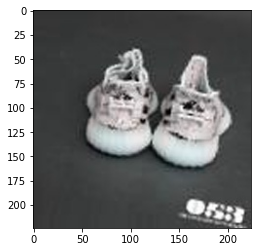

In [48]:
## Check out first img(resized)

img = resize[0, : ]
plt.figure()
plt.imshow(img)
print(resize.shape)  

In [49]:
## Make X (feature)

X = resize
X.shape  

(2500, 224, 224, 3)

## Create Label

### Create Csv file

In [50]:
## Make csv file in path_re

path_re = "E:\\image\\shoes\\##resize_ver4\\d_re.csv"

# loader_shoes_func.csv_maker_10(path_re, k1=498, k2=495, k3=496, k4=498, k5=500,
#                           k6=778, k7=533, k8=636, k9=592, k10=675)


loader_shoes_func.csv_maker_5(path_re, k1=500, k2=500, k3=500, k4=500, k5=500)


### Load y : label

In [51]:
import loader_shoes_func

path_re = "E:\\image\\shoes\\##resize_ver4\\d_re.csv"

#y = loader_shoes_func.label_load(path_re,label_cnt=10)  #label_cnt = len(신발종류)
y = loader_shoes_func.label_load(path_re,label_cnt=5)  #label_cnt = len(신발종류)
y.shape

(2500, 5)

## Scailing

In [52]:
X = X.astype('float')
X = X/255
X.shape  

(2500, 224, 224, 3)

## Check X, y

In [53]:
## Confirm X, y
print(X.shape)  
print(y.shape, end='\n\n\n')  

# print("#####Check out : X#####")
# print(X, end='\n\n\n')
# print("#####Check out : y#####")
# print(y)

(2500, 224, 224, 3)
(2500, 5)




# Modeling

## VGG16

### Import module 

In [69]:
## module import
import tensorflow as tf # tensorflow 2.0
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


## Transfer learning (전이학습)
from tensorflow.keras.applications.vgg16 import VGG16                        
from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.resnet import ResNet50

In [70]:
## Check tensorFlow version

print (tf.__version__)

2.1.0


### Validation data (Train:val=0.7:0.3)

In [71]:
# 훈련/테스트 데이터를 0.7/0.3의 비율로 분리합니다.
x_train, x_val, y_train, y_val = train_test_split(X, y, 
                                                test_size = 0.3, 
                                                random_state = 777)

# Checkout
print(x_train.shape)
print(x_val.shape)  
print(y_train.shape)
print(y_val.shape)  

(1750, 224, 224, 3)
(750, 224, 224, 3)
(1750, 5)
(750, 5)


### Set Vgg16 options

In [96]:
## VGG16 options

vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [97]:
## 가중치 초기값 : imagenet
# layer.trainable=True : 동결 해제 (default)
# layer.trainable=False : 동결 (option)

for layer in vgg16.layers[:15]:
    layer.trainable = False

In [98]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Vgg16 뒷부분 신경망 생성

In [99]:
# 신경망 객체 생성
model = Sequential()

# stacking vgg16
model.add(vgg16)

# Reshape : Flatten 
model.add(Flatten())

# 완전연결계층1
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1.5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 완전연결계층2
model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1.5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 출력층(softmax)
#model.add(Dense(10))  # class : 10
model.add(Dense(5))  # class : 5
model.add(Activation('softmax'))

# Check out model 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               6422784   
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

### Compile

In [100]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr = 0.0001), 
              metrics=['accuracy'])

### fitting

In [101]:
## Parameters
epochs = 6
batch_size=100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)  #Early stopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    

## Fitting
hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val), 
                 epochs=epochs, 
                 batch_size=batch_size,
                 callbacks = [callback])

Train on 1750 samples, validate on 750 samples
Epoch 1/6
1750/1750 [==============================] - 9s 5ms/sample - loss: 903.0421 - accuracy: 0.3937 - val_loss: 777.9752 - val_accuracy: 0.5413
Epoch 2/6
1750/1750 [==============================] - 8s 5ms/sample - loss: 689.8115 - accuracy: 0.7291 - val_loss: 596.5749 - val_accuracy: 0.7760
Epoch 3/6
1750/1750 [==============================] - 8s 5ms/sample - loss: 532.2133 - accuracy: 0.8874 - val_loss: 465.2849 - val_accuracy: 0.8853
Epoch 4/6
1750/1750 [==============================] - 8s 5ms/sample - loss: 419.4186 - accuracy: 0.9480 - val_loss: 372.2128 - val_accuracy: 0.9787
Epoch 5/6
1750/1750 [==============================] - 8s 5ms/sample - loss: 339.7372 - accuracy: 0.9714 - val_loss: 306.6353 - val_accuracy: 0.9987
Epoch 6/6
1750/1750 [==============================] - 8s 5ms/sample - loss: 283.6381 - accuracy: 0.9771 - val_loss: 260.4375 - val_accuracy: 0.9987


In [102]:
## Check out accuracy (with independent data)
scores3 = model.evaluate(ind_X, ind_y, verbose=0)

print("Vgg16 ind_dataset Error : %.2f%%" % (100-scores3[1]*100))
print("Vgg16 ind_dataset Error : %.2f" % (scores3[0]))

Vgg16 ind_dataset Error : 2.00%
Vgg16 ind_dataset Error : 260.79


### Visualization

In [103]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [104]:
## log : Accuracy
from pandas import DataFrame

Sample = [hist.history['accuracy'],hist.history['val_accuracy']]
df = DataFrame(Sample).transpose()
df.columns = ['train_Acc', 'val_Acc']
df

,train_Acc,val_Acc
0,0.393714,0.541333
1,0.729143,0.776000
2,0.887429,0.885333
3,0.948000,0.978667
4,0.971429,0.998667
5,0.977143,0.998667


In [105]:
## log : Loss 
Sample2 = [hist.history['loss'],hist.history['val_loss']]

df2 = DataFrame(Sample2).transpose()
df2.columns = ['train_Loss', 'val_loss']
df2

,train_Loss,val_loss
0,903.042064,777.975191
1,689.811501,596.574939
2,532.213258,465.284924
3,419.418551,372.212815
4,339.737183,306.635284
5,283.638083,260.437522


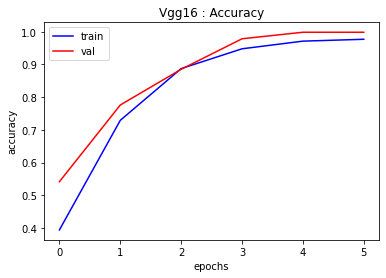

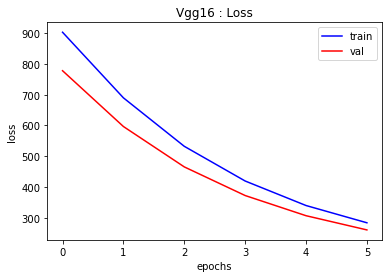

In [106]:
## Visualization : Accuracy
plt.plot(hist.history['accuracy'], color='blue')
plt.plot(hist.history['val_accuracy'], color='red')
plt.title('Vgg16 : Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Visualization : Loss
plt.plot(hist.history['loss'], color='blue')
plt.plot(hist.history['val_loss'], color='red')
plt.title('Vgg16 : Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Results

In [107]:
## Check out accuracy

scores = model.evaluate(x_train, y_train, verbose=0)
scores2 = model.evaluate(x_val, y_val, verbose=0)

print("Vgg16 train Error : %.2f%%" % (100-scores[1]*100))
print("Vgg16 val Error : %.2f%%" % (100-scores2[1]*100))
print(' ')
print("Vgg16 train Loss : %.2f" % (scores[0]))
print("Vgg16 val Loss : %.2f" % (scores2[0]))

Vgg16 train Error : 0.00%
Vgg16 val Error : 0.13%
 
Vgg16 train Loss : 260.40
Vgg16 val Loss : 260.44


### Save model : .h5 file

In [218]:
## Save model : .h5(Hdf5 type file)

save_path = "e:\\shoes_vgg16_d.h5"
save_model(model, save_path)  

# Testing with 'independent data'

## Resize

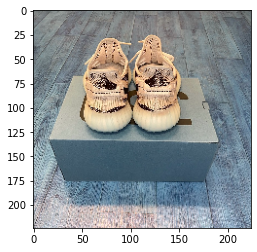

img shape (224, 224, 3)


In [2]:
## Resize & create file by order:asc
## for independent testing data

import loader_shoes_func
ind_path_raw = "E:\\image\\shoes\\##resize_ver4\\ind_d_raw"
ind_path_re = "E:\\image\\shoes\\##resize_ver4\\ind_d_resize"

loader_shoes_func.resize(ind_path_raw, ind_path_re, height=224, width=224)  #default = 128*128

## Load ind_X

In [3]:
## Load X : Features

ind_path_re = "E:\\image\\shoes\\##resize_ver4\\ind_d_resize"
ind_resize = loader_shoes_func.image_load(ind_path_re)

(50, 224, 224, 3)


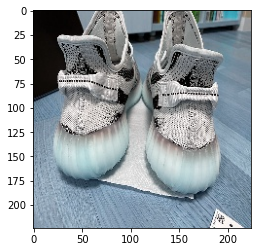

In [4]:
## Check out first img(resized)
img = ind_resize[0, : ]
plt.figure()
plt.imshow(img)
print(ind_resize.shape)  

In [5]:
## Make ind_X (feature)
ind_X = ind_resize
ind_X.shape  

(50, 224, 224, 3)

## Create Label & Load ind_y

In [6]:
## Create Label

ind_path_re = "E:\\image\\shoes\\##resize_ver4\\ind_d_re.csv"

# loader_shoes_func.csv_maker_10(ind_path_re, k1=10, k2=10, k3=10, k4=10, k5=10,
#                          k6=10, k7=10, k8=10, k9=10, k10=10)

loader_shoes_func.csv_maker_5(ind_path_re, k1=10, k2=10, k3=10, k4=10, k5=10)
                      

In [7]:
## Load ind_y : Label

ind_path_re = "E:\\image\\shoes\\##resize_ver4\\ind_d_re.csv"

ind_y = loader_shoes_func.label_load(ind_path_re,label_cnt=5)  #label_cnt = len(신발종류)
ind_y.shape

(50, 5)

## Scaling

In [8]:
ind_X = ind_X.astype('float')
ind_X = ind_X/255
ind_X.shape  

(50, 224, 224, 3)

## Check ind_X, ind_y

In [9]:
## Confirm X, y
print(ind_X.shape)
print(ind_y.shape)  

# print("#####Check out : X#####")
# print(X, end='\n\n\n')
# print("#####Check out : y#####")
# print(y)

(50, 224, 224, 3)
(50, 5)


## Results

In [33]:
## Check out Error

scores3 = model.evaluate(ind_X, ind_y, verbose=0)

print("Vgg16 ind_dataset Error : %.2f%%" % (100-scores3[1]*100))

Vgg16 ind_dataset Error : 20.00%
